# 12 - Predicting BNB profit of future trends by multiple Models, with BTC data

Similar to the previous notebook, but now we are using the BTC data to predict the BNB profit of future trends.

Also it seems that the previous model lack of neutral trend trainning data, so I will try skipping undersampling this time

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from util import *
from nbeat import *
from operator import itemgetter

bnb_data = pd.read_csv('data/BNBUSDT_1D_2.csv')
bnb_close_values = bnb_data['Close']
btc_data = pd.read_csv('data/BTCUSDT_1D_2.csv')
btc_close_values = btc_data['Close']

future_period = 21
profit_of_future_log = covertToLogScale(computeProfitOfFuture(bnb_close_values, future_period))

skip_count = 390

bnb_close_data = bnb_data['Close'][skip_count:-future_period]
btc_close_data = btc_data['Close'][skip_count:-future_period]
bnb_input_scale = np.max(bnb_close_data)
btc_input_scale = np.max(btc_close_data)
print(f"bnb_input_scale: {bnb_input_scale}")
print(f"btc_input_scale: {btc_input_scale}")

input_data = np.column_stack([
  bnb_close_data,
  btc_close_data,
])
output_data = profit_of_future_log[skip_count:]

dataSize = len(input_data)
assert(dataSize == len(output_data))
windowSize = future_period * 2 # TODO:
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

output_scale = np.max(profit_of_future_log)
print(f"output_scale: {output_scale}")

x_train = prepareTrainingInputs(input_data, windowSize, testSize)
y_train = prepareTraingingOutputs(output_data, windowSize, testSize)
x_test = prepareTestingInputs(input_data, windowSize, testSize)
y_test = prepareTestingOutputs(output_data, testSize)

# try not to use undersampling this time
# x_train_rs, y_train_rs = undersampleSeriesDataTomekBySign(x_train, y_train)
# x_test_rs, y_test_rs = undersampleSeriesDataTomekBySign(x_test, y_test)

bnb_input_scale: 676.967
btc_input_scale: 67606.96
dataSize: 1010
windowSize: 42
testSize: 303
output_scale: 5.841402995389024


In [2]:
# refer to 09-pof-singlemodel.ipynb
ut_target = 2.5
dt_target = -2.5
nt_target = 2.9
scaling = 3 / 2.5

up_trend_train, down_trend_train, neutral_trend_train = computeUDNTrend(y_train, ut_target, dt_target, nt_target, scaling)
up_trend_test, down_trend_test, neutral_trend_test = computeUDNTrend(y_test, ut_target, dt_target, nt_target, scaling)

print(f"train up trend mean: {np.mean(up_trend_train)}")
print(f"train down trend mean: {np.mean(down_trend_train)}")
print(f"train neutral trend mean: {np.mean(neutral_trend_train)}")
print(f"test up trend mean: {np.mean(up_trend_test)}")
print(f"test down trend mean: {np.mean(down_trend_test)}")
print(f"test neutral trend mean: {np.mean(neutral_trend_test)}")

train up trend mean: 0.42518626076409777
train down trend mean: 0.48147154017092353
train neutral trend mean: 0.42070086257550193
test up trend mean: 0.3167541279275107
test down trend mean: 0.382530473592114
test neutral trend mean: 0.7641873925316252


Trivial prediction brenchmarking

In [3]:
test_count = len(up_trend_test)
trivial_prediction = np.full([test_count], np.tanh(3))
up_rmse0 = tf.keras.metrics.RootMeanSquaredError()(trivial_prediction, up_trend_test).numpy()
down_rmse0 = tf.keras.metrics.RootMeanSquaredError()(trivial_prediction, down_trend_test).numpy()
trivial_prediction = np.ones(test_count)
neutral_rmse0 = tf.keras.metrics.RootMeanSquaredError()(trivial_prediction, neutral_trend_test).numpy()
print(f"RMSE up: {up_rmse0:.2f}, down: {down_rmse0:.2f}, neutral: {neutral_rmse0:.2f}")

RMSE up: 0.81, down: 0.76, neutral: 0.39


In [4]:
datasets = [
  { 'y_train': up_trend_train, 'y_test': up_trend_test, 'x_train': x_train, 'x_test': x_test, 'name': "Up trend" },
  { 'y_train': down_trend_train, 'y_test': down_trend_test, 'x_train': x_train, 'x_test': x_test, 'name': "Down trend" },
  { 'y_train': neutral_trend_train, 'y_test': neutral_trend_test, 'x_train': x_train, 'x_test': x_test, 'name': "Neutral trend" },
]



#### [Model1] ARIMA

================= Up trend training ================


10/10 [==============================] - 1s 57ms/step - loss: 0.2311 - mse: 0.2311
loss: 0.4807061485023089
corr: 0.1133355148540707

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.
Restoring model weights from the end of the best epoch: 5.

Epoch 15: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.
Epoch 15: early stopping
10/10 [==============================] - 3s 49ms/step - loss: 0.1983 - mse: 0.1983
loss: 0.4453573538961838
corr: 0.10076334063265807
================= Down trend training ================
10/10 [==============================] - 2s 49ms/step - loss: 0.1994 - mse: 0.1994
loss: 0.4464951421285447
corr: 0.33378205133808

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.
Restoring model weights from the end of the best epoch: 4.

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.
Epoch 14: early stopping
10/10 [==============================] - 1s 52ms/step - loss: 0.19

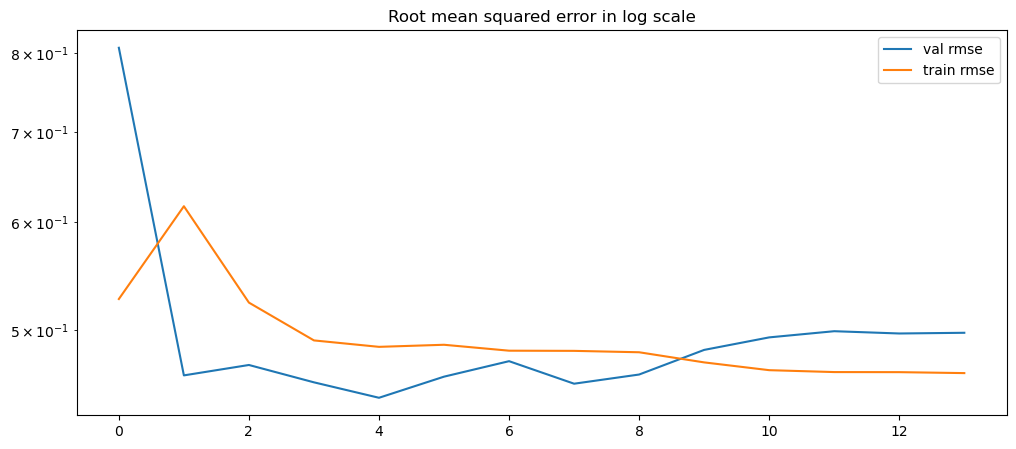

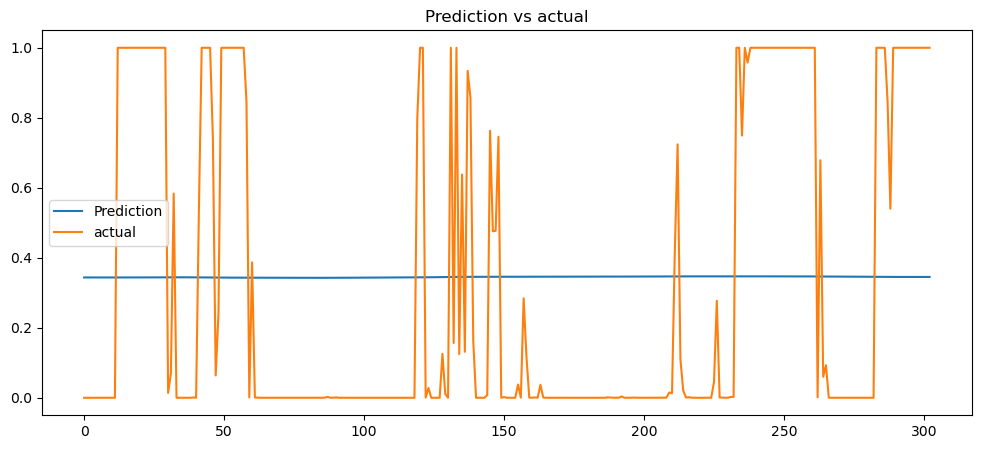

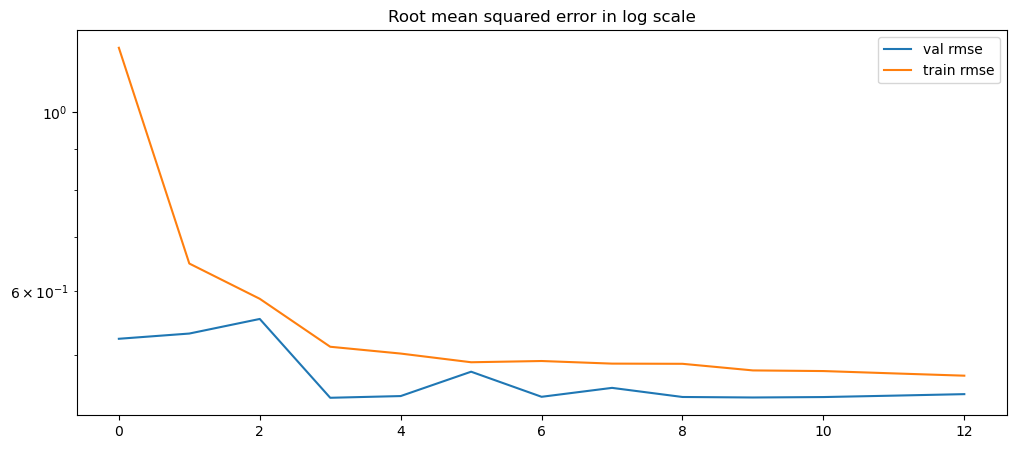

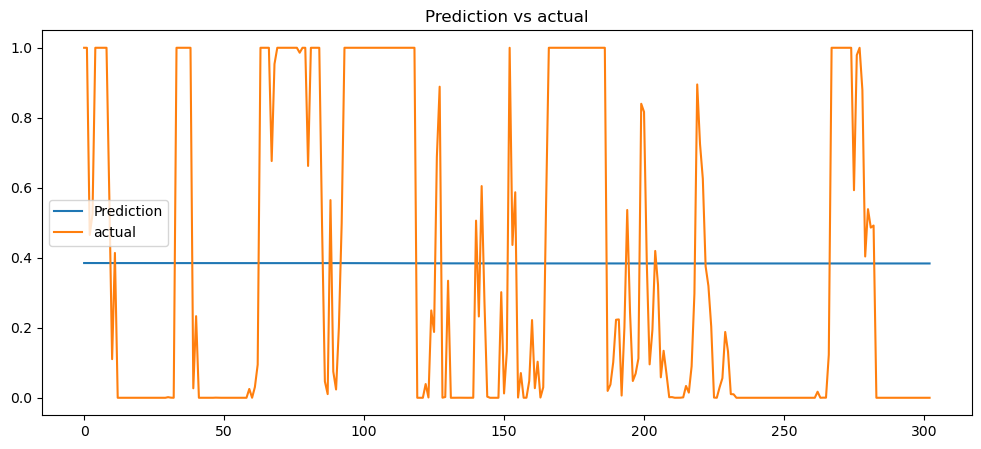

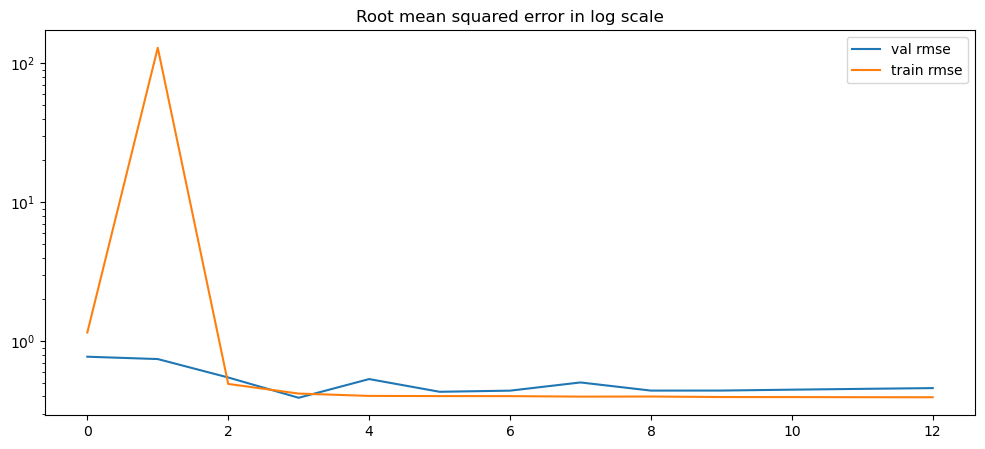

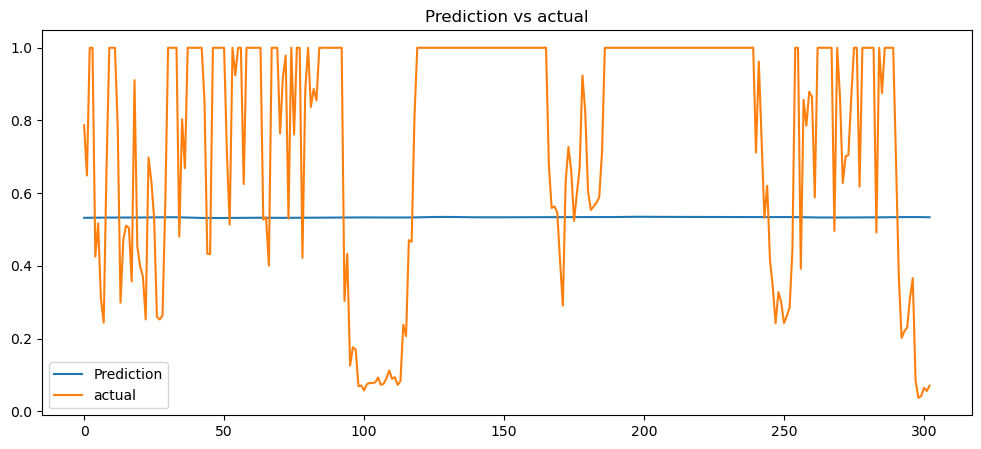

In [35]:
neuronCount = 128

for dataset in datasets:
  name, x_tr, y_tr, x_t, y_t = itemgetter('name', 'x_train', 'y_train', 'x_test', 'y_test')(dataset)
  train_dataset, test_dataset = prepareDataSetFromArray(x_tr, y_tr, x_t, y_t, shuffle=True, batch_size=256)
  print(f"================= {name} training ================")
  # Create input to stacks
  input = layers.Input(shape=(windowSize,2), name="stack_input")
  x = input
  x = tf.keras.layers.multiply([x, np.array([[1/bnb_input_scale, 1/btc_input_scale]])])
  x = tf.keras.layers.LSTM(neuronCount, activation='relu', return_sequences=True)(x)
  x = tf.keras.layers.LSTM(round(neuronCount/2), activation='relu', return_sequences=True)(x)
  # residual
  residual = tf.keras.layers.LSTM(round(neuronCount/2), return_sequences=True)(input)  # Skip connection
  x = tf.keras.layers.Add()([x, residual])  # Adding the residual connection
  x = tf.keras.layers.LSTM(round(neuronCount/4), activation='relu')(x)
  # dense layers
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(32, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation="linear")(x)
  model = tf.keras.Model(inputs=input, outputs=x)
  dataset['model1'] = model
  # train for few epochs first
  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mse"])
  noValidationTrainingAndReport(model, x_t, y_t, train_dataset, epochs=5, plotGraph=False)
  # supervised training with lower learning rate
  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.005),
                metrics=["mse"])
  history, rmse, corr = standardTrainingAndReport(model, x_t, y_t, train_dataset, test_dataset)
  dataset['history1'] = history
  dataset['rmse1'] = rmse
  dataset['corr1'] = corr

##### Training predictions

Text(0.5, 1.0, 'Training prediction (no norm)')

<Figure size 640x480 with 0 Axes>

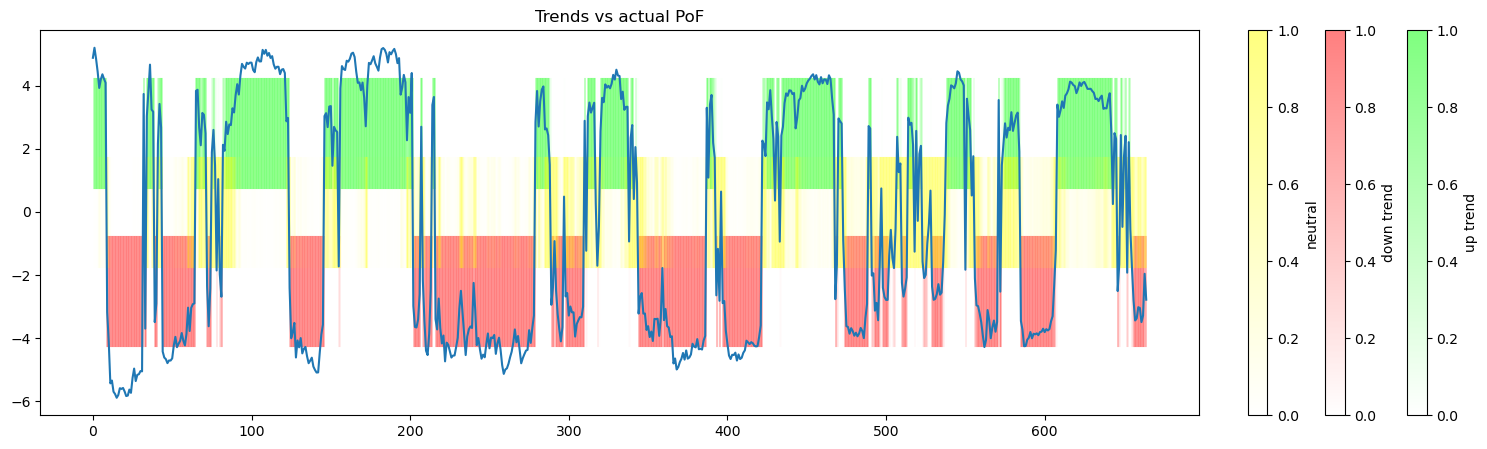

<Figure size 640x480 with 0 Axes>

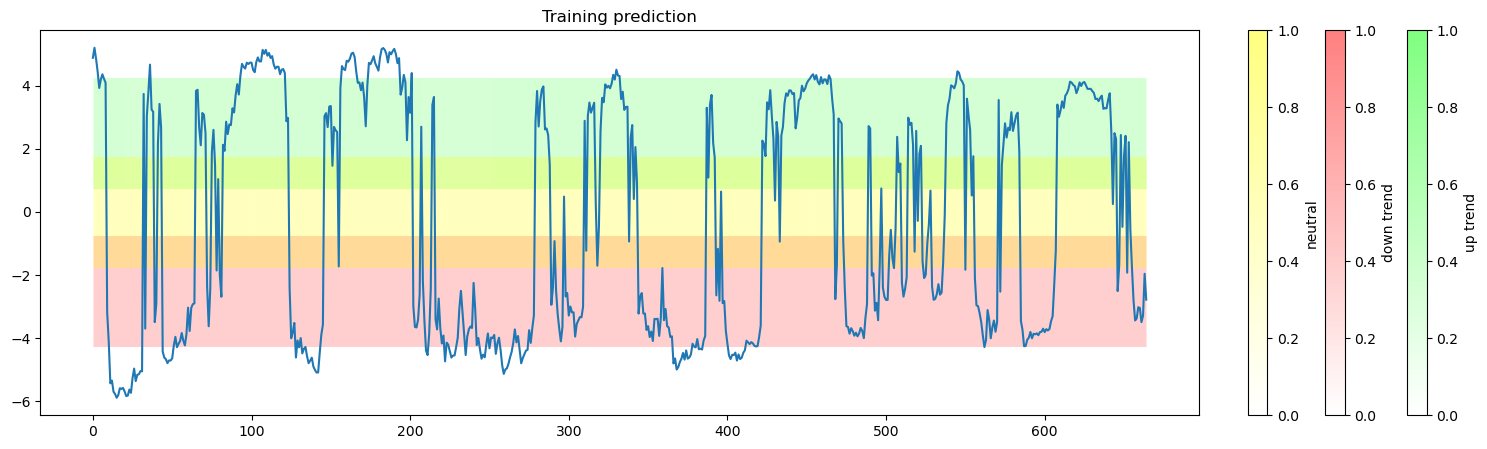

<Figure size 640x480 with 0 Axes>

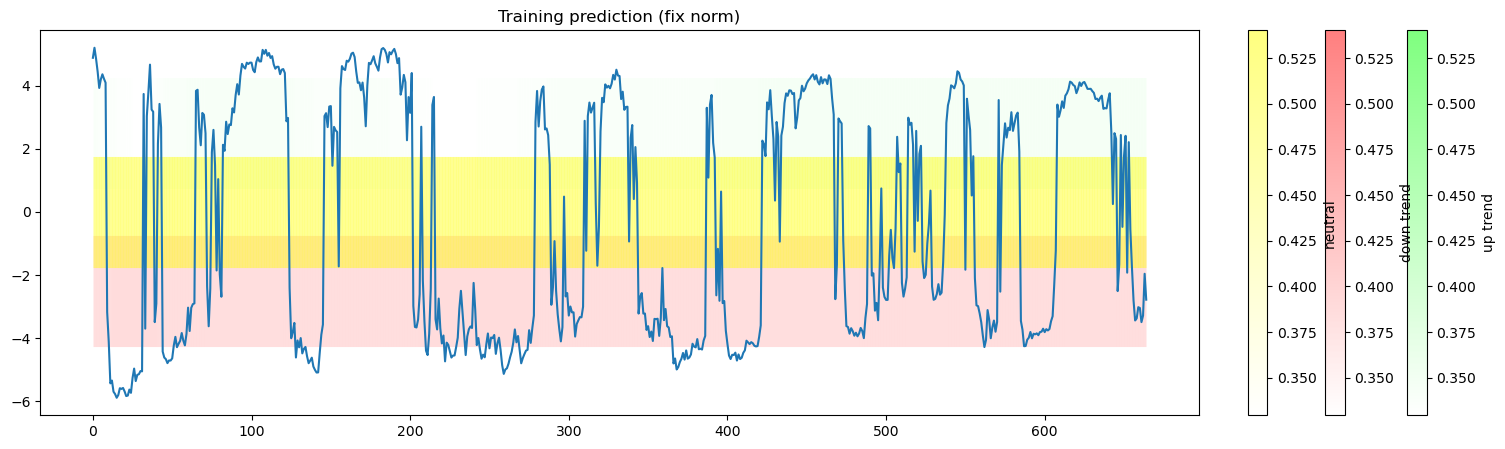

<Figure size 640x480 with 0 Axes>

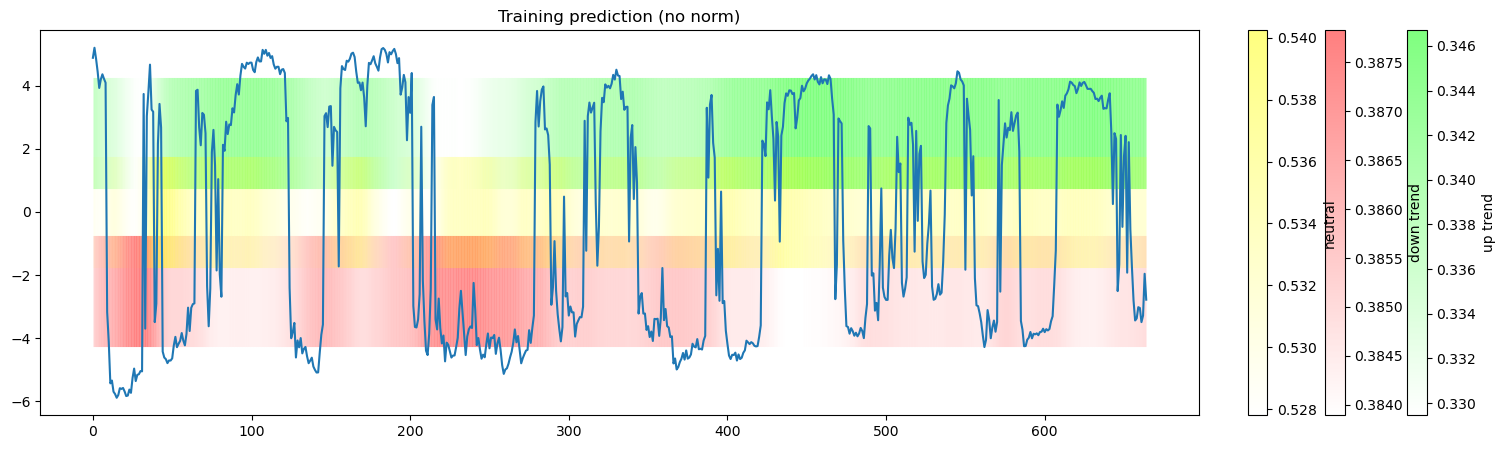

In [36]:
prediction = np.column_stack([dataset['model1'].predict(dataset['x_train']) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target)
ax.plot(y_train, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_train, label='actual')
ax.set_title('Training prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_train, label='actual')
ax.set_title('Training prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_train, label='actual')
ax.set_title('Training prediction (no norm)')


##### Testing predictions

Text(0.5, 1.0, 'Testing prediction (no norm)')

<Figure size 640x480 with 0 Axes>

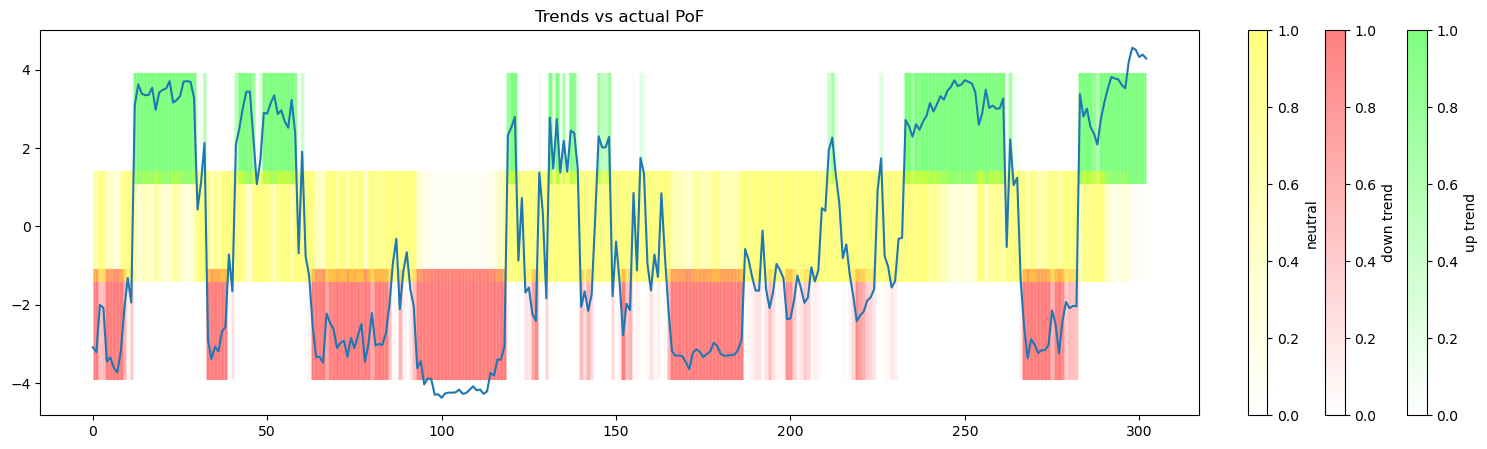

<Figure size 640x480 with 0 Axes>

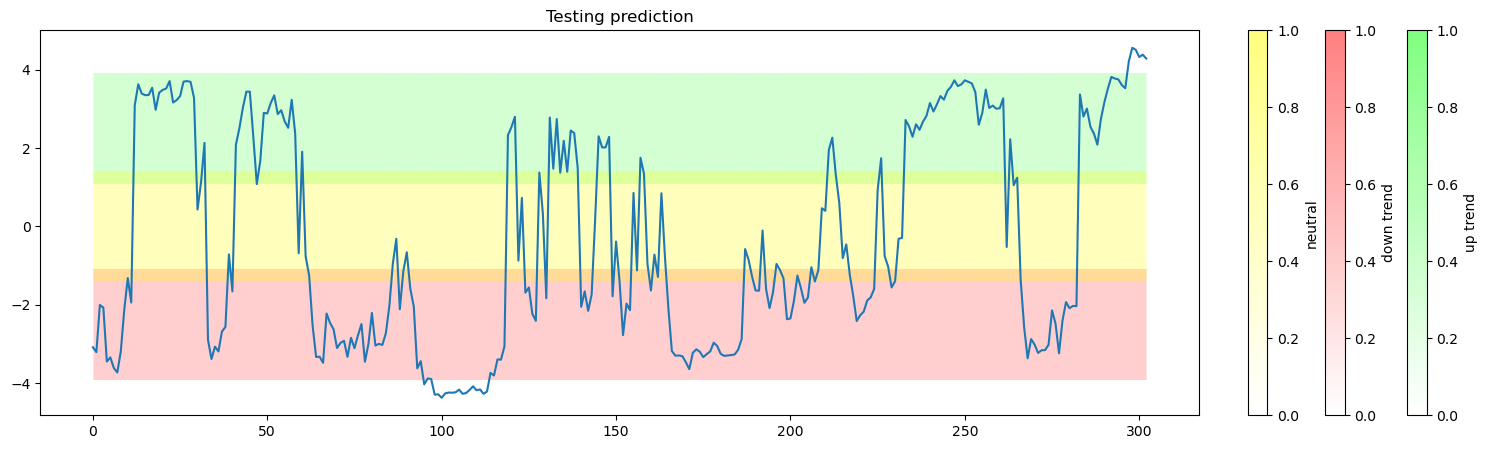

<Figure size 640x480 with 0 Axes>

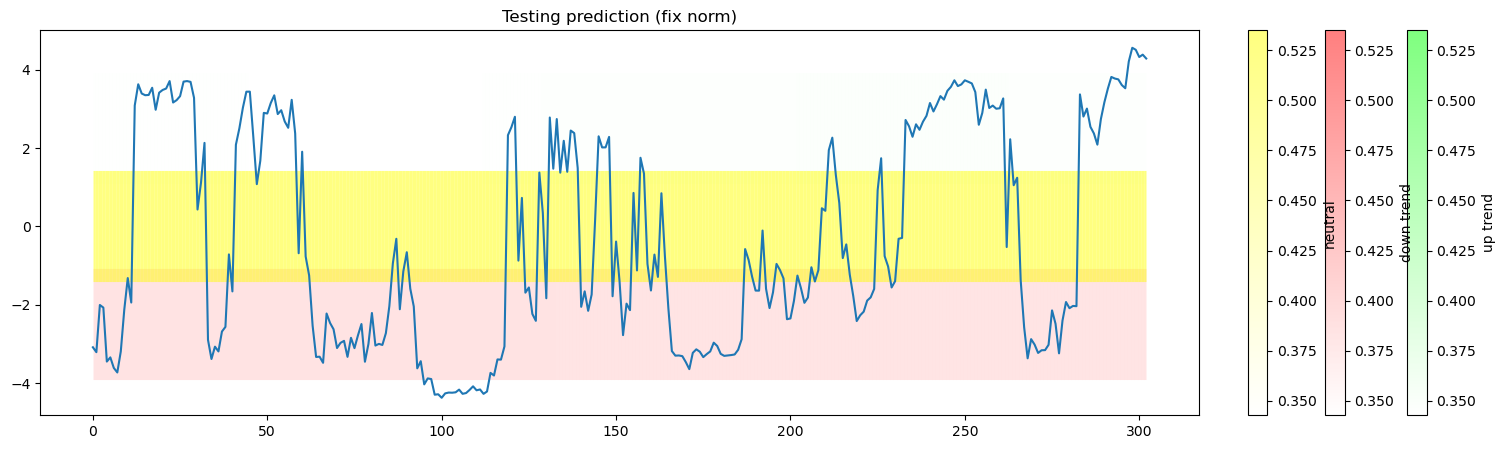

<Figure size 640x480 with 0 Axes>

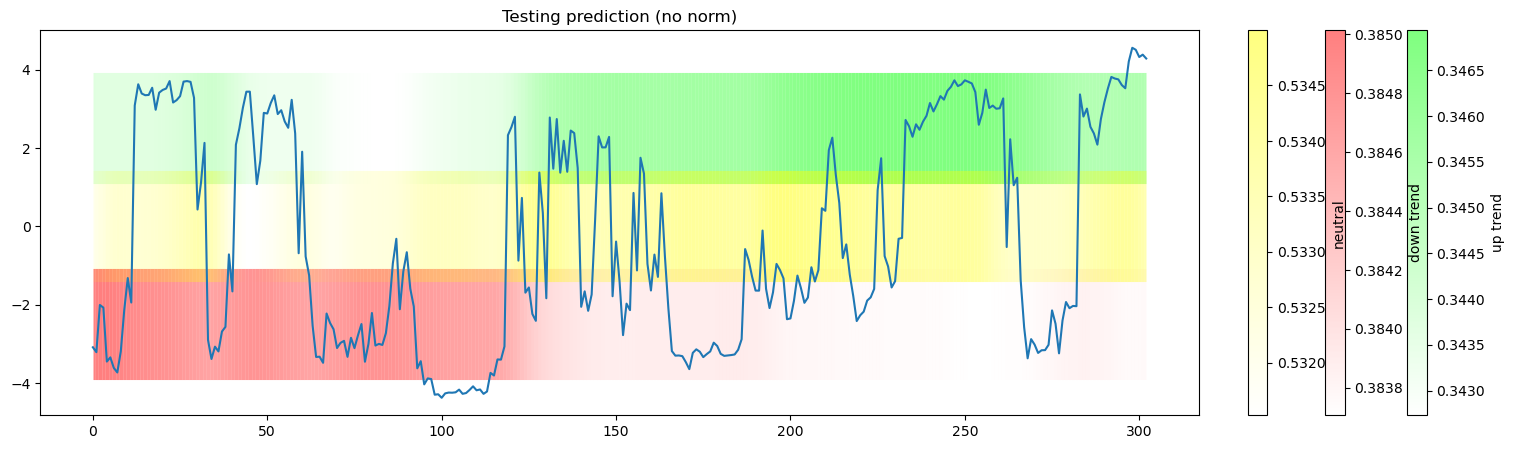

In [37]:
prediction = np.column_stack([dataset['model1'].predict(dataset['x_test']) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_test, down_trend_test, neutral_trend_test, ut_target)
ax.plot(y_test, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_test, label='actual')
ax.set_title('Testing prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_test, label='actual')
ax.set_title('Testing prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_test, label='actual')
ax.set_title('Testing prediction (no norm)')

#### [Model2] N-BEATS

================= Up trend training ================
10/10 [==============================] - 2s 22ms/step - loss: 0.1862 - mse: 0.1862
loss: 0.43146675370879667
corr: 0.31174738562274334
10/10 [==============================] - 1s 16ms/step - loss: 0.2444 - mse: 0.2444
loss: 0.4943988110466275
corr: 0.21044591798014817

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Restoring model weights from the end of the best epoch: 3.

Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.
Epoch 13: early stopping
10/10 [==============================] - 1s 18ms/step - loss: 0.1952 - mse: 0.1952
loss: 0.44182598783729804
corr: 0.21278539821451806
================= Down trend training ================
10/10 [==============================] - 1s 20ms/step - loss: 0.2294 - mse: 0.2294
loss: 0.47892223910201864
corr: 0.29760399619447797
10/10 [==============================] - 2s 33ms/step - loss: 0.2274 - mse: 0.2274
loss: 0.4768813583030132
corr: 

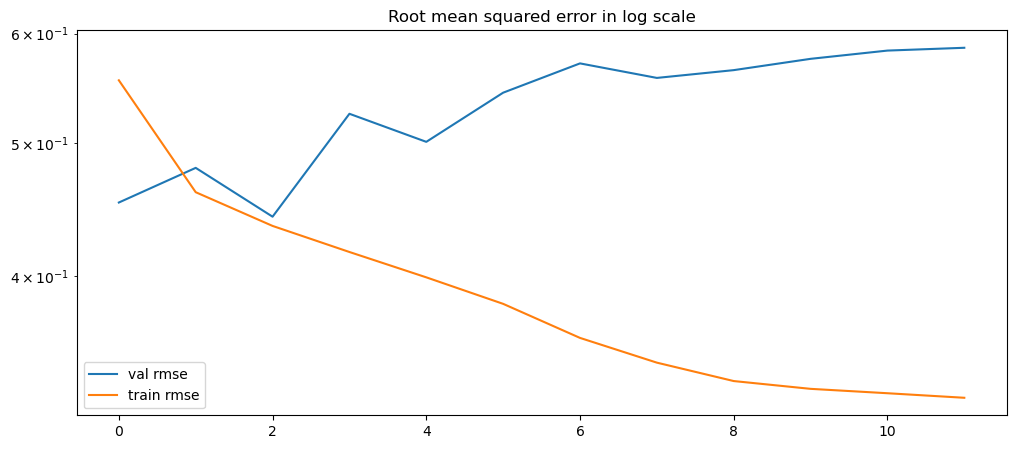

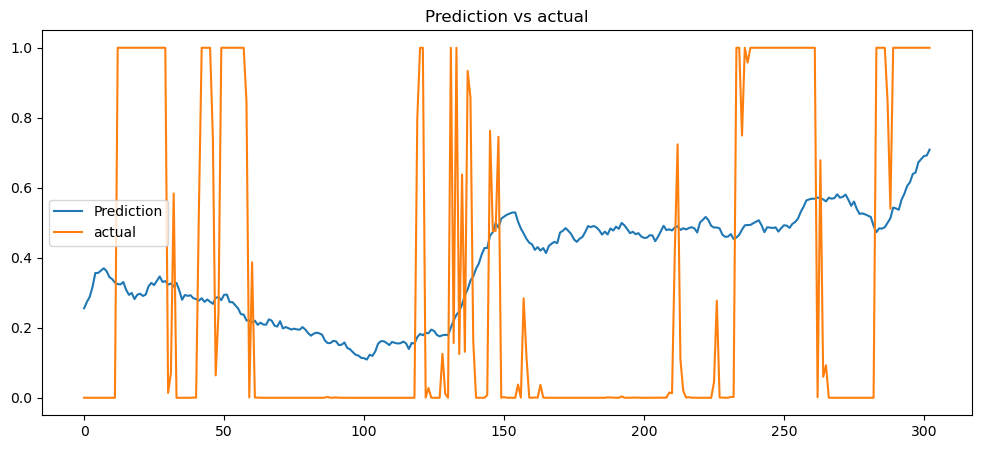

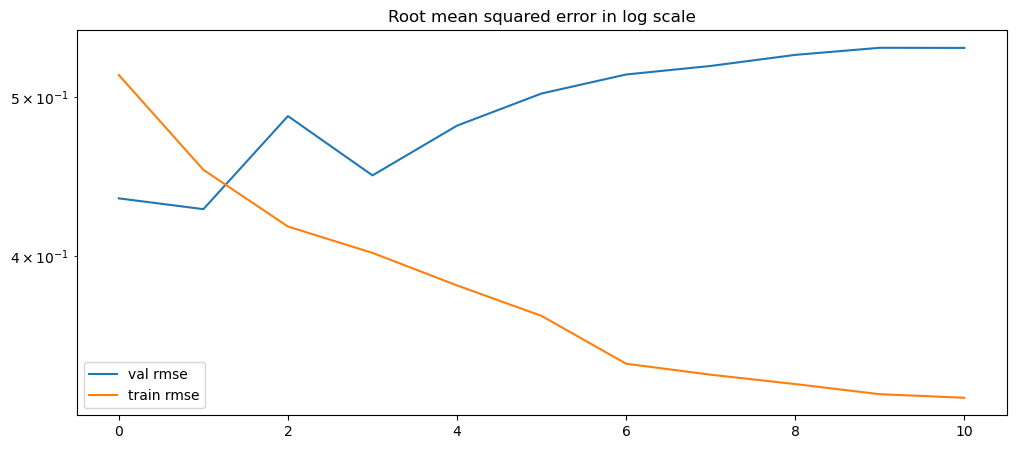

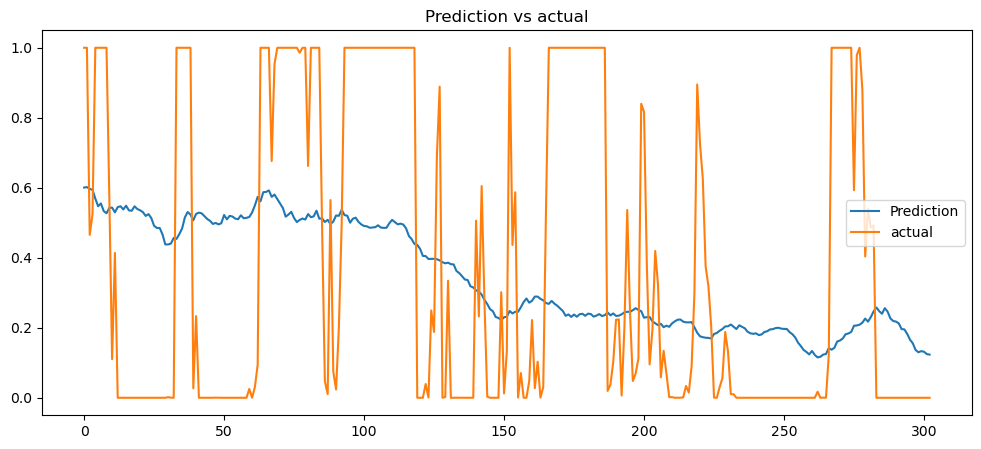

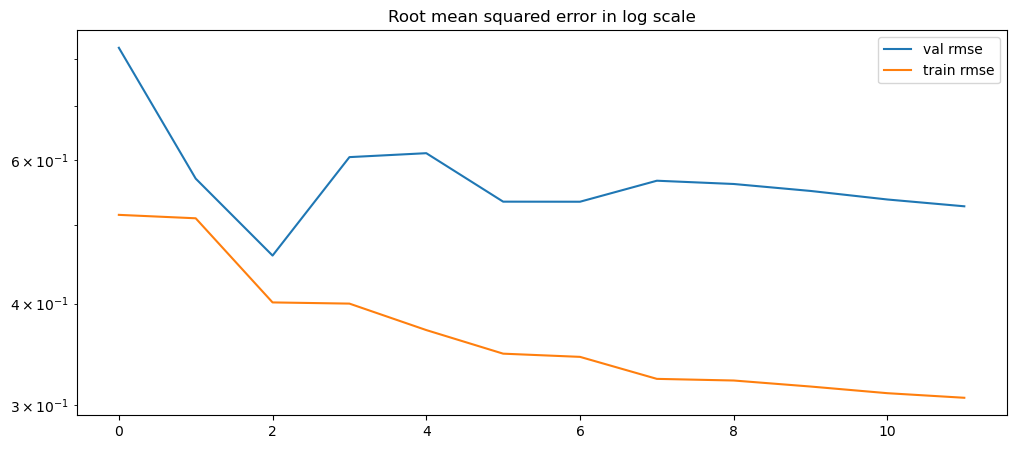

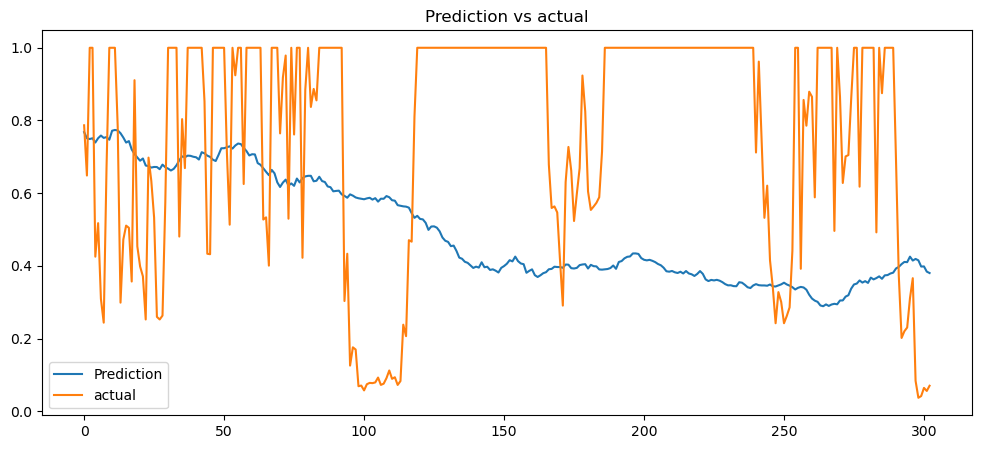

In [42]:
for dataset in datasets:
  name, x_tr, y_tr, x_t, y_t = itemgetter('name', 'x_train', 'y_train', 'x_test', 'y_test')(dataset)
  # FIXME:
  # x_tr = (x_tr * [1./bnb_input_scale, 1./btc_input_scale]).reshape(-1, windowSize*2)
  # x_t = (x_t * [1./bnb_input_scale, 1./btc_input_scale]).reshape(-1, windowSize*2)
  x_tr = x_tr.reshape(-1, windowSize*2)
  x_t = x_t.reshape(-1, windowSize*2)
  # transform input data
  train_dataset, test_dataset = prepareDataSetFromArray(x_tr, y_tr, x_t, y_t, shuffle=True, batch_size=256)
  print(f"================= {name} training ================")
  nbeatNeuronCount = 512
  nBeatLayerCount = 4
  nBeatStackCount = 30
  input = layers.Input(shape=(windowSize*2), name="stack_input")
  x = input
  # FIXME:
  # x = tf.keras.layers.multiply([
  #   x,
  #   np.tile([1./bnb_input_scale, 1./btc_input_scale], windowSize)
  # ])
  # x = tf.keras.layers.multiply([
  #   x,
  #   tf.constant(np.tile([1., 1.], windowSize))
  # ])
  x = x * tf.constant([np.tile([1./bnb_input_scale, 1./btc_input_scale], windowSize)], dtype=tf.float32) 
  x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)
  model = tf.keras.Model(inputs=input, outputs=x)
  dataset['model2'] = model
  # train for few epoches first
  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.00025),
                metrics=["mse"])
  noValidationTrainingAndReport(model, x_t, y_t, train_dataset, epochs=7, plotGraph=False)
  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["mse"])
  noValidationTrainingAndReport(model, x_t, y_t, train_dataset, epochs=3, plotGraph=False)
  # train again for lower learning rate
  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.00005),
                metrics=["mse"])
  history, rmse, corr = standardTrainingAndReport(model, x_t, y_t, train_dataset, test_dataset)
  dataset['history2'] = history
  dataset['rmse2'] = rmse
  dataset['corr2'] = corr

Text(0.5, 1.0, 'Training prediction (no norm)')

<Figure size 640x480 with 0 Axes>

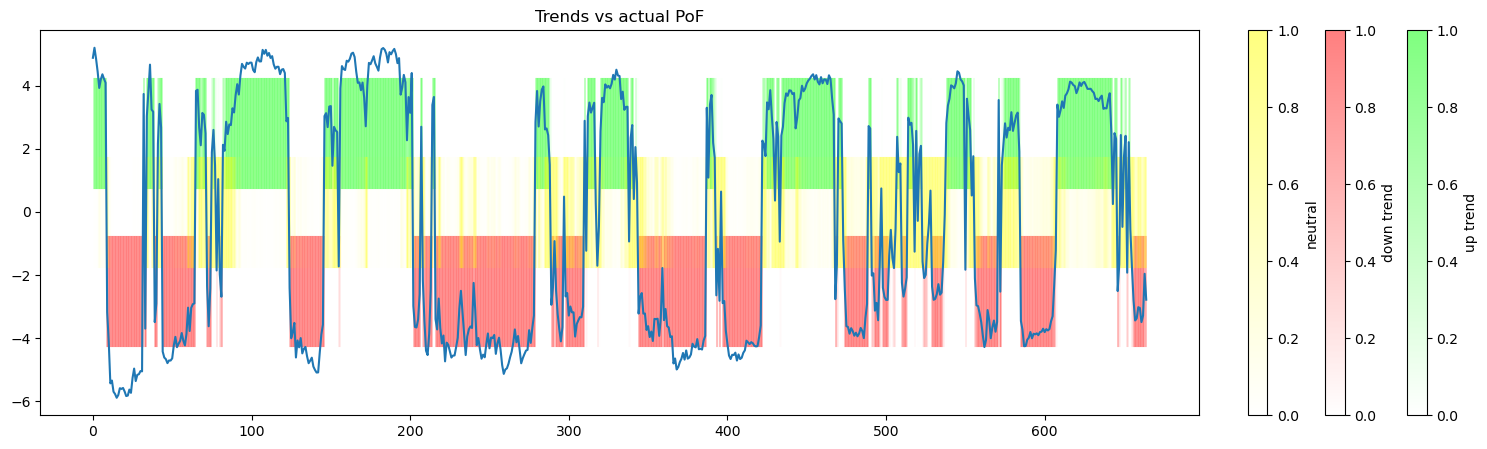

<Figure size 640x480 with 0 Axes>

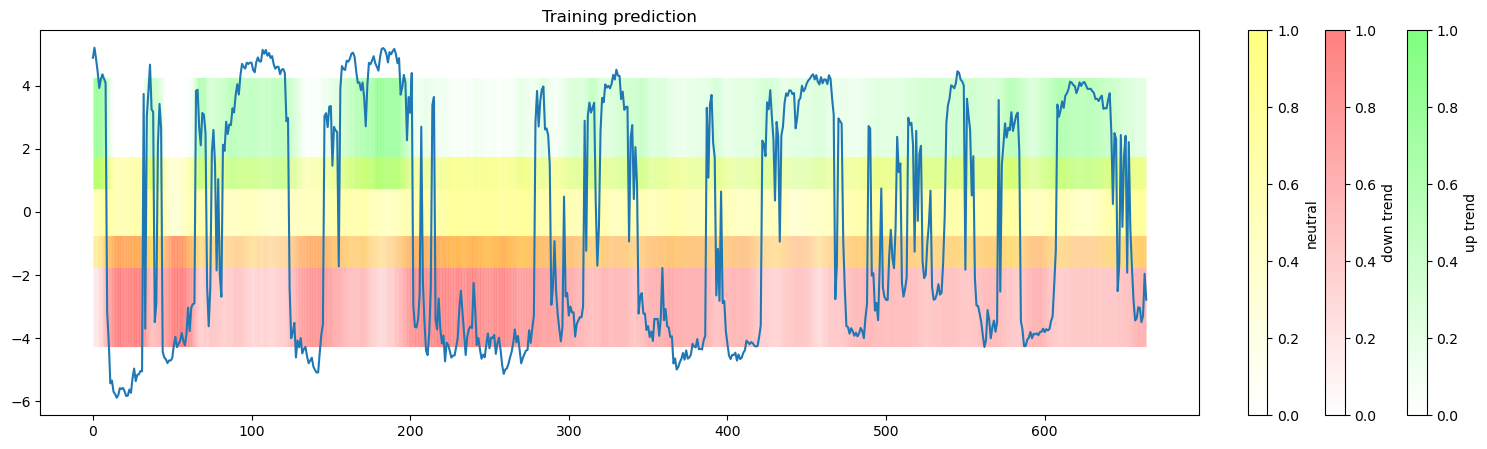

<Figure size 640x480 with 0 Axes>

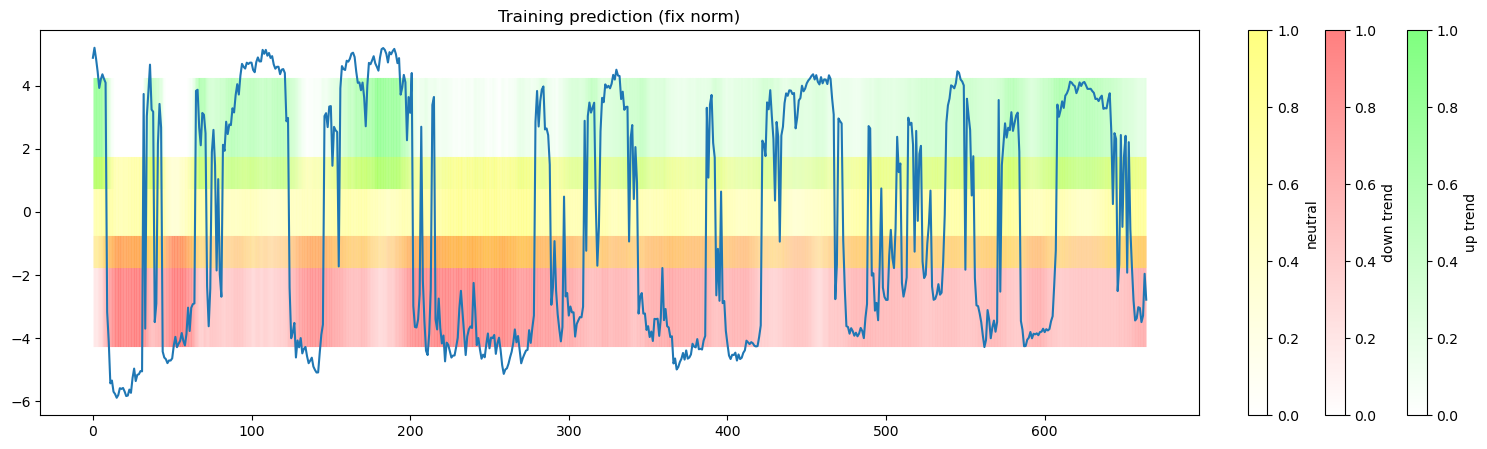

<Figure size 640x480 with 0 Axes>

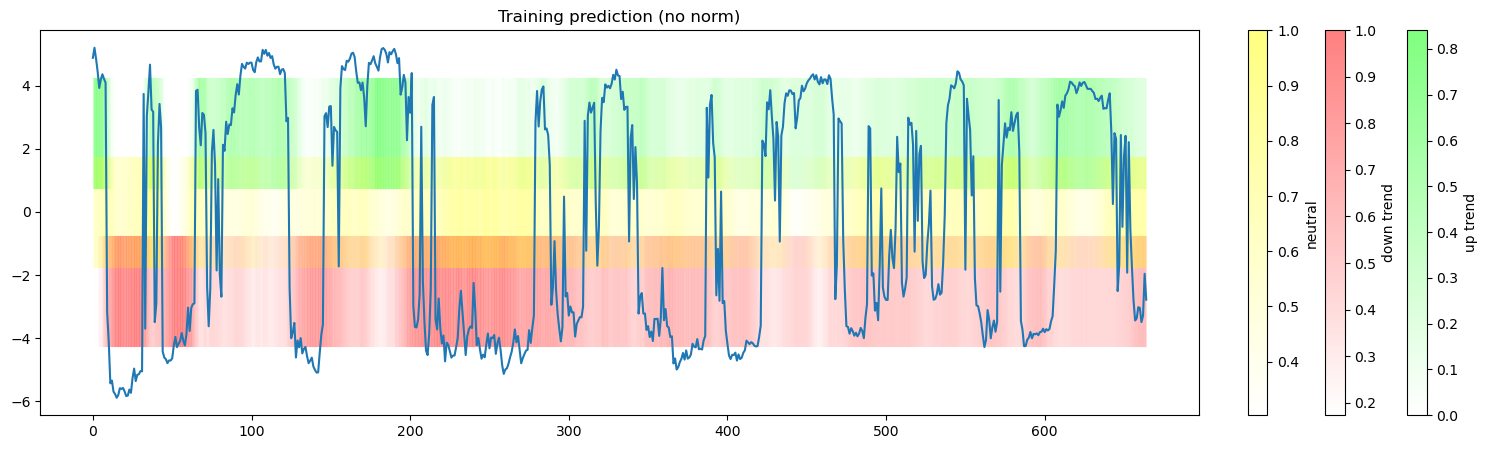

In [43]:
prediction = np.column_stack([dataset['model2'].predict(dataset['x_train'].reshape(-1, windowSize*2)) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_train, down_trend_train, neutral_trend_train, ut_target)
ax.plot(y_train, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_train, label='actual')
ax.set_title('Training prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_train, label='actual')
ax.set_title('Training prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_train, label='actual')
ax.set_title('Training prediction (no norm)')


Text(0.5, 1.0, 'Testing prediction (no norm)')

<Figure size 640x480 with 0 Axes>

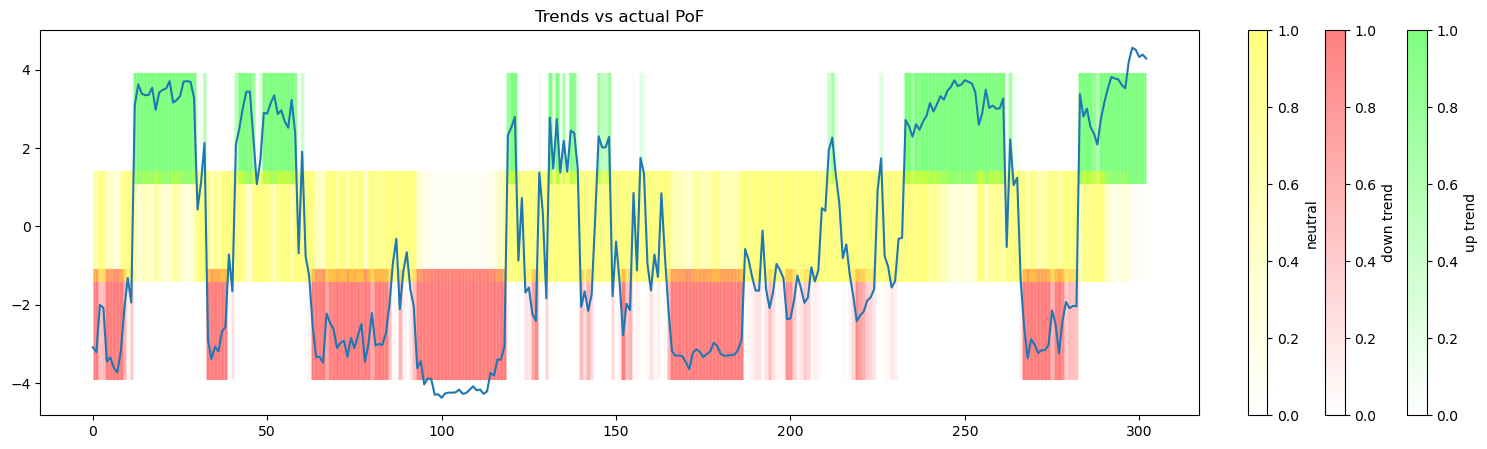

<Figure size 640x480 with 0 Axes>

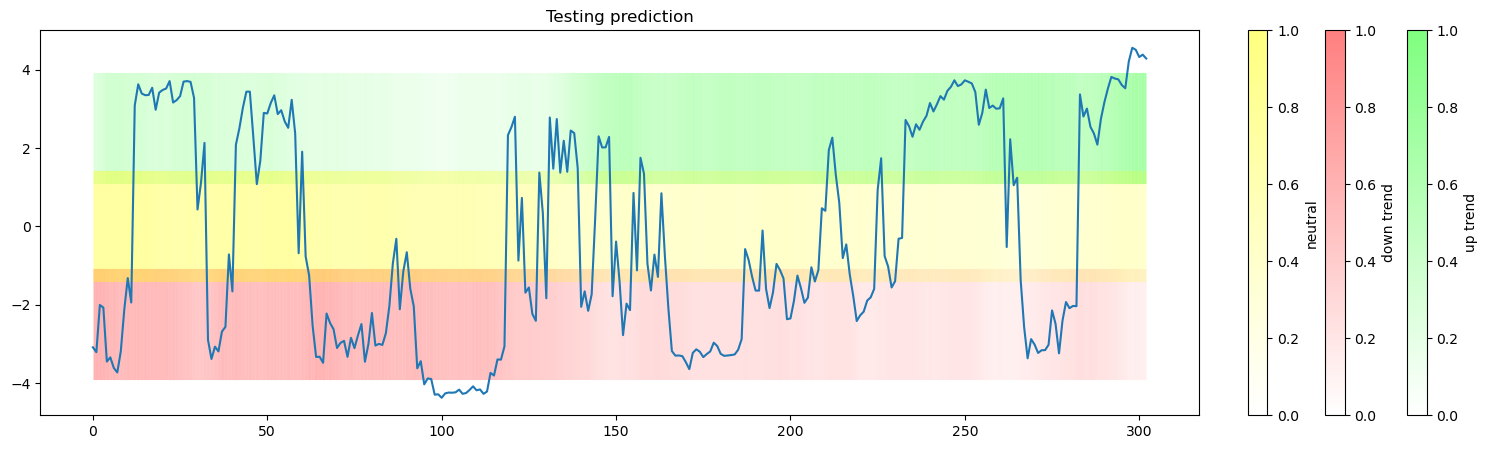

<Figure size 640x480 with 0 Axes>

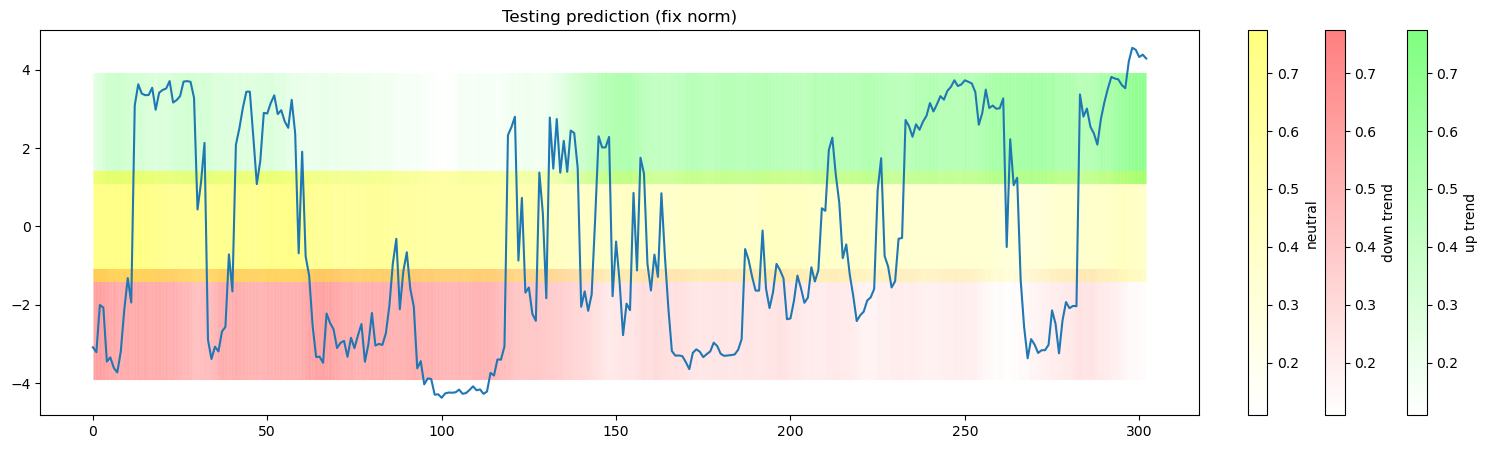

<Figure size 640x480 with 0 Axes>

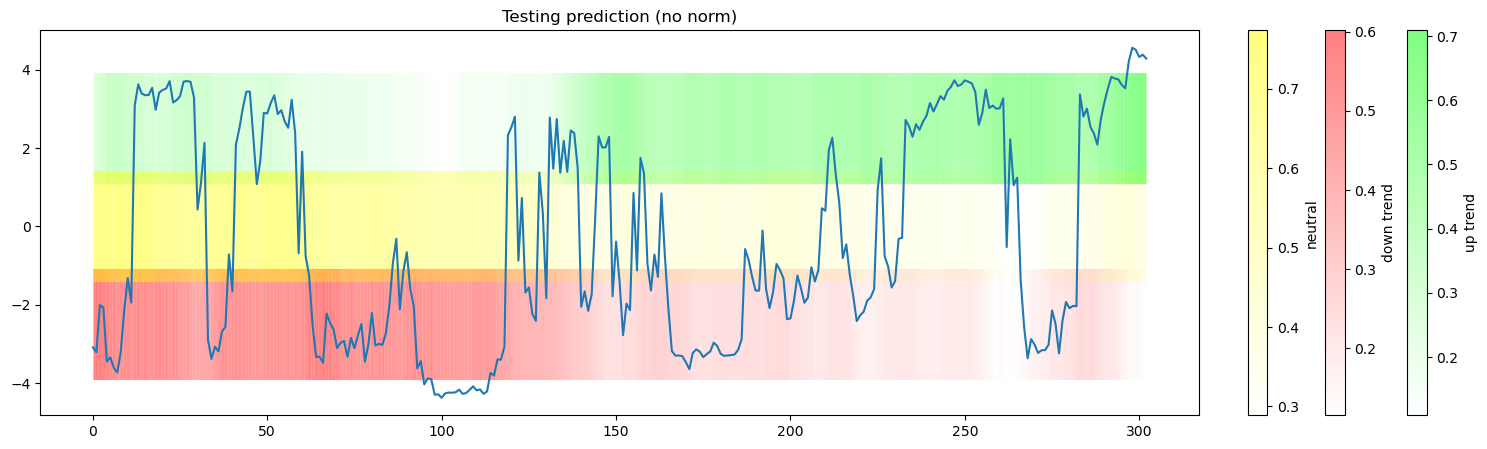

In [44]:
prediction = np.column_stack([dataset['model2'].predict(dataset['x_test'].reshape(-1, windowSize*2)) for dataset in datasets])

# clip prediction before plotting
dataCount = len(prediction)
prediction = np.clip(prediction, np.zeros([dataCount, 3]), np.ones([dataCount, 3]))

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, up_trend_test, down_trend_test, neutral_trend_test, ut_target)
ax.plot(y_test, label='actual')
ax.set_title('Trends vs actual PoF')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target)
ax.plot(y_test, label='actual')
ax.set_title('Testing prediction')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=Normalize(vmin=np.min(prediction), vmax=np.max(prediction)))
ax.plot(y_test, label='actual')
ax.set_title('Testing prediction (fix norm)')

plt.figure()
fig, ax = plt.subplots(figsize=(18, 5))
drawBarsForTrends(fig, ax, prediction[:,0], prediction[:,1], prediction[:,2], ut_target, norm=None)
ax.plot(y_test, label='actual')
ax.set_title('Testing prediction (no norm)')

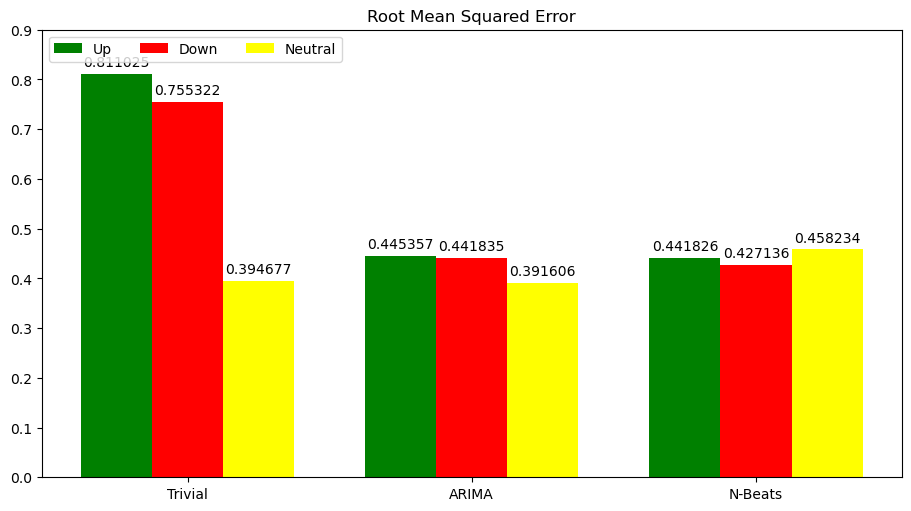

In [46]:
species = ("Trivial", "ARIMA", "N-Beats")
rmses = {
    'Up': { 'measurement': [up_rmse0, datasets[0]['rmse1'], datasets[0]['rmse2']], 'color': 'green' },
    'Down': { 'measurement': [down_rmse0, datasets[1]['rmse1'], datasets[1]['rmse2']], 'color': 'red' },
    'Neutral': { 'measurement': [neutral_rmse0, datasets[2]['rmse1'], datasets[2]['rmse2']], 'color': 'yellow' },
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(9, 5))

for attribute, info in rmses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, info['measurement'], width, label=attribute, color=info['color'])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Root Mean Squared Error')
ax.set_xticks(x + width, species)
ax.set_ylim(0, 0.9)
ax.legend(loc='upper left', ncols=3)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_14556\2299841305.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', ncols=3)


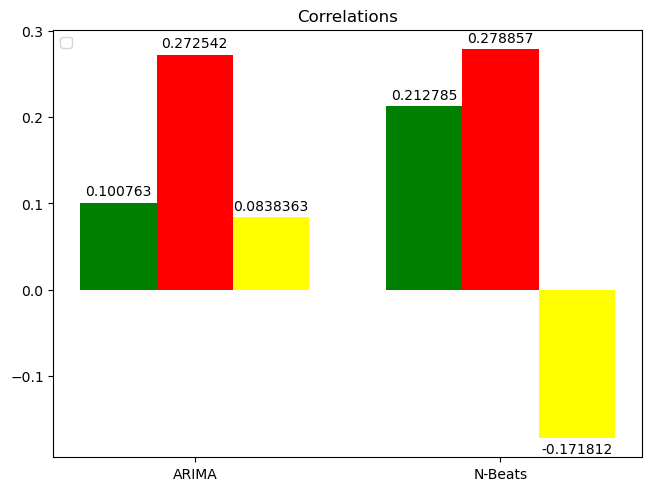

In [45]:
species = ("ARIMA", "N-Beats")
rmses = {
    'Up': { 'measurement': [datasets[0]['corr1'], datasets[0]['corr2']], 'color': 'green' },
    'Down': { 'measurement': [datasets[1]['corr1'], datasets[1]['corr2']], 'color': 'red' },
    'Neutral': { 'measurement': [datasets[2]['corr1'], datasets[2]['corr2']], 'color': 'yellow' }
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, info in rmses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, info['measurement'], width, color=info['color'])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Correlations')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
plt.show()


The model seems worst with BTC data